In [20]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import random
import torch
import time
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [21]:
all_letters = "АаӘәБбВвГгҒғДдЕеЁёЖжЗзИиЙйКкҚқЛлМмНнҢңОоӨөПпРрСсТтУуҮүҰұФфХхҺһЦцЧчШшЩщЪъЫыІіЬьЭэЮюЯя"

def filterLetters(letters):
    return ''.join([letter for letter in letters if letter in all_letters])

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [filterLetters(line) for line in lines]

names = readLines('data/Kazakh.txt')

In [22]:
class RNN(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = torch.nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = torch.nn.Linear(input_size + hidden_size, output_size)
        self.o2o = torch.nn.Linear(hidden_size + output_size, output_size)
        self.dropout = torch.nn.Dropout(0.2)
        self.softmax = torch.nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
        

In [23]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, len(all_letters) + 1)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(len(all_letters))
    return torch.LongTensor(letter_indexes)

def randomTrainingExample():
    name = randomChoice(names)
    input_line_tensor = inputTensor(name)
    target_line_tensor = targetTensor(name)
    return input_line_tensor, target_line_tensor

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [24]:
criterion = torch.nn.NLLLoss()

learning_rate = 0.0005

def train(input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item() / input_line_tensor.size(0)

In [25]:
rnn = RNN(len(all_letters) + 1, 128, len(all_letters) + 1)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:882.)


0m 23s (5000 5%) 2.8250
0m 51s (10000 10%) 3.3203
1m 15s (15000 15%) 2.7687
1m 42s (20000 20%) 2.4374
2m 10s (25000 25%) 3.1410
2m 32s (30000 30%) 1.3566
2m 54s (35000 35%) 2.0700
3m 17s (40000 40%) 2.0893
3m 45s (45000 45%) 2.4224
4m 16s (50000 50%) 1.8270
4m 42s (55000 55%) 2.3433
5m 8s (60000 60%) 2.6221
5m 35s (65000 65%) 2.6437
6m 0s (70000 70%) 3.1761
6m 25s (75000 75%) 3.4605
6m 49s (80000 80%) 3.1266
7m 15s (85000 85%) 2.4641
7m 39s (90000 90%) 3.6028
8m 2s (95000 95%) 2.0901
8m 26s (100000 100%) 2.7717


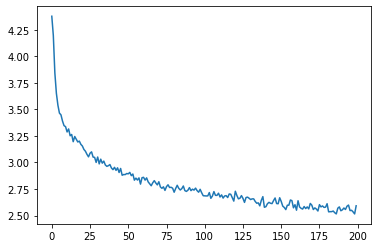

In [7]:
plt.figure()
plt.plot(all_losses)

In [49]:
max_length = 20

def sample(start_letters):
    with torch.no_grad():
        
        input = inputTensor(start_letters[0])
        hidden = rnn.initHidden()

        output_name = start_letters[0]

        for i in range(1, max_length + 1):
            output, hidden = rnn(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            
            if i < len(start_letters):
                letter = start_letters[i]
            else:
                if topi == len(all_letters):
                    break
                else:
                    letter = all_letters[topi]
            
            output_name += letter
            input = inputTensor(letter)

        return output_name

In [74]:
values = set()
for i in range(10):
    values.add(sample('А'))
print(values)

{'Алайы', 'Айбет', 'Айбайта', 'Айбек', 'Алай', 'Айбал', 'Айбай', 'Айтар'}
